In [4]:
#Importing necessary Python Libraries.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy import sparse
from scipy.sparse import hstack

**SCORING FUNCTION**

In [5]:
#https://www.kaggle.com/davidgasquez/ndcg-scorer

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """ 
    Calculating Discounted cumulative gain (DCG) at rank K.

    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(te_labels, predict, k):       
    """
    Calculating Normalized discounted cumulative gain (NDCG) at rank K.
  
    """

    lb = LabelBinarizer()
    lb.fit(range(len(predict) + 1))
    T = lb.transform(te_labels)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predict):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        if best == 0:
            best = 0.000000001
        score = float(actual) / float(best)
        scores.append(score)
    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

**FUNCTION FOR REDUCING THE MEMORY USAGE**

In [6]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    
    """ 
    Function that iterates through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
#Loading data 
X_t = pd.read_csv('/content/drive/MyDrive/DataSets/Pre_Processed_train.csv')

In [8]:
#Applying user-defined function to reduce memory of the dataset:
data=reduce_mem_usage(X_t)

Memory usage of dataframe is 514.61 MB
Memory usage after optimization is: 128.45 MB
Decreased by 75.0%


In [9]:
X = data.drop(['y_tr'],axis=1)
y = data.y_tr

**FUNCTION FOR SPLITTING TRAIN DATA BASED ON TIME INTO TRAIN AND VALIDATION SETS**

In [10]:
#https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets

def time_based_splitting(Data):
  
  X = Data.year_account_created
  Y = Data.month_account_created

  train_start_index = 0
  train_end_index = Data[(X==2010) & (Y==12)].index[-1]+1
  train_index = []
  test_index = []

  for i in range(2011,2015):
    if (i!=2014):
      for j in range(2,13,2):
        test_start_index = train_end_index 
        test_end_index = Data[(X==i)&(Y==j)].index[-1]+1
        train_index.append(np.arange(train_start_index,train_end_index))
        test_index.append(np.arange(test_start_index,test_end_index))
        train_end_index = test_end_index
    else:
      for j in range(2,7,2):
        test_start_index = train_end_index 
        test_end_index = Data[(X==i)&(Y==j)].index[-1]+1
        train_index.append(np.arange(train_start_index,train_end_index))
        test_index.append(np.arange(test_start_index,test_end_index))
        train_end_index = test_end_index
  
  return train_index,test_index

In [11]:
train_index,test_index = time_based_splitting(X)
Xc = sparse.csr_matrix(X.to_numpy())

#**LOGISTIC REGRESSION**

In [12]:
#Building Logistic Regression model with 'L1' Regularization
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm

alpha = [10 ** x for x in range(-3, 1)]
init_score_l1 = 0
print('Hypertuning Logistic Regression Classifier with "L1" Regularization for best parameters:\n')
for i in tqdm(alpha):
    scores = [] 
    for tr,te in zip(train_index,test_index):
      lr = LogisticRegression(penalty='l1',C=i,solver='saga')
      lr.fit(Xc[tr],y[tr])
      prob_lr = lr.predict_proba(Xc[te])
      score_lr = ndcg_score(y[te], prob_lr, k=5)
      scores.append(score_lr)
    if (np.mean(scores) > init_score_l1):
        alpha_best_l1 = i 
        init_score_l1 = np.mean(scores)
    print('\nFor alpha : {0}, NDCG Score : {1}'.format(i,np.mean(scores)))

print('\nThe Best parameter (alpha) is {} with an NDCG score of {}'.format(alpha_best_l1,init_score_l1))

Hypertuning Logistic Regression Classifier with "L1" Regularization for best parameters:



 25%|██▌       | 1/4 [07:11<21:34, 431.64s/it]


For alpha : 0.001, NDCG Score : 0.776857806440388


 50%|█████     | 2/4 [15:28<15:39, 469.85s/it]


For alpha : 0.01, NDCG Score : 0.777312539707233


 75%|███████▌  | 3/4 [26:35<09:20, 560.08s/it]


For alpha : 0.1, NDCG Score : 0.7800229350242146


100%|██████████| 4/4 [42:00<00:00, 630.00s/it]


For alpha : 1, NDCG Score : 0.7804860510833629

The Best parameter (alpha) is 1 with an NDCG score of 0.7804860510833629


In [15]:
#Training the Logistic Regression model with L1 Regularization with best alpha and storing into a pickle file:
from sklearn.linear_model import LogisticRegression
lr_clf_l1 = LogisticRegression(penalty='l1',C=alpha_best_l1,solver='saga')
lr_clf_l1.fit(Xc,y)
pickle.dump(lr_clf_l1,open('/content/drive/MyDrive/DataSets/LOGISTIC_REGRESSION_MODEL_L1','wb'))

#**DECISION TREE MODEL**

In [ ]:
#Building Decision Tree model
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
max_depth=[1,2,3,4,5,6]
min_samples_split=[5,10,50,100]

init_score_dt = 0
print('Hypertuning Decision tree Classifier for best parameters:\n')
for i in max_depth:
    print("Depth of tree : {}".format(i))
    for j in min_samples_split:
      scores = [] 
      for tr,te in zip(train_index,test_index):     
        d_tree = DecisionTreeClassifier(criterion='gini', max_depth=i , min_samples_split= j,random_state=42)
        d_tree.fit(Xc[tr],y[tr])
        prob_dt = d_tree.predict_proba(Xc[te])
        score_dt = ndcg_score(y[te], prob_dt, k=5)
        scores.append(score_dt)
      if (np.mean(scores) > init_score_dt):
          depth_dt, min_sample = i , j
          init_score_dt = np.mean(scores)
      print ("    min_sample_split : {}, \n    NDCG Score : {}\n    -------------------".format(j,np.mean(scores)))

print('\nThe Best parameters are: \nmax_depth: {} \nmin_sample_split: {}'.format(depth_dt, min_sample))
print('with an NDCG score of {}'.format(init_score_dt))

Hypertuning Decision tree Classifier for best parameters:

Depth of tree : 1
    min_sample_split : 5, 
    NDCG Score : 0.7825966093807373
    -------------------
    min_sample_split : 10, 
    NDCG Score : 0.7825966093807373
    -------------------
    min_sample_split : 50, 
    NDCG Score : 0.7825966093807373
    -------------------
    min_sample_split : 100, 
    NDCG Score : 0.7825966093807373
    -------------------
Depth of tree : 2
    min_sample_split : 5, 
    NDCG Score : 0.7879962617785936
    -------------------
    min_sample_split : 10, 
    NDCG Score : 0.7879962617785936
    -------------------
    min_sample_split : 50, 
    NDCG Score : 0.7879962617785936
    -------------------
    min_sample_split : 100, 
    NDCG Score : 0.7879962617785936
    -------------------
Depth of tree : 3
    min_sample_split : 5, 
    NDCG Score : 0.7903271501717037
    -------------------
    min_sample_split : 10, 
    NDCG Score : 0.7903271501717037
    -------------------
    min_

In [ ]:
#Training the Decision Tree Classifier with best parameters and storing into a pickle file:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth= depth_dt , min_samples_split= min_sample,random_state=42 )
dt_clf.fit(Xc,y)
pickle.dump(dt_clf,open('/content/drive/MyDrive/DataSets/DECISION_TREE_MODEL','wb'))

#**RANDOM FOREST**

In [ ]:
#Building Random forest model
from sklearn.ensemble import RandomForestClassifier

n_estimator= [5,10,50,100] 
max_depth= [1,2,3,4,5,6]
init_score_rf = 0
print('Hypertuning Random forest Classifier for best parameters:\n')

for i in max_depth:
    print("Depth of tree : {}".format(i))
    for j in (n_estimator):
      scores = [] 
      for tr,te in zip(train_index,test_index):
        clf_rf = RandomForestClassifier(n_estimators=j, criterion='gini', max_depth=i, random_state=42, n_jobs=-1)
        clf_rf.fit(Xc[tr],y[tr])
        prob_rf = clf_rf.predict_proba(Xc[te])
        score_rf = ndcg_score(y[te], prob_rf, k=5)
        scores.append(score_rf)
      if (np.mean(scores) > init_score_rf):
          depth_rf, n_estimator_rf = i , j
          init_score_rf = np.mean(scores)
      print ("    n_estimators : {}, \n    NDCG Score : {}\n    -------------------".format(j,np.mean(scores)))

print('\nThe Best parameters are: \nmax_depth: {} \nn_estimators: {}'.format(depth_rf, n_estimator_rf))
print('with an NDCG score of {}'.format(init_score_rf))

Hypertuning Random forest Classifier for best parameters:

Depth of tree : 1
    n_estimators : 5, 
    NDCG Score : 0.7820134759053464
    -------------------
    n_estimators : 10, 
    NDCG Score : 0.781683971769842
    -------------------
    n_estimators : 50, 
    NDCG Score : 0.7830131727131466
    -------------------
    n_estimators : 100, 
    NDCG Score : 0.782760484666564
    -------------------
Depth of tree : 2
    n_estimators : 5, 
    NDCG Score : 0.7835514650179112
    -------------------
    n_estimators : 10, 
    NDCG Score : 0.786447278480482
    -------------------
    n_estimators : 50, 
    NDCG Score : 0.7861985752997911
    -------------------
    n_estimators : 100, 
    NDCG Score : 0.7864526402828892
    -------------------
Depth of tree : 3
    n_estimators : 5, 
    NDCG Score : 0.7873982277590494
    -------------------
    n_estimators : 10, 
    NDCG Score : 0.7880024382682824
    -------------------
    n_estimators : 50, 
    NDCG Score : 0.78861353

In [ ]:
#Training the Random Forest Classifier with best parameters and storing into a pickle file:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators= n_estimator_rf, criterion='gini', max_depth=depth_rf, random_state=42, n_jobs=-1)
clf_rf.fit(X,y)
pickle.dump(clf_rf,open('/content/drive/MyDrive/DataSets/RANDOM_FOREST_MODEL','wb'))

#**XG BOOST MODEL**

In [ ]:
#Building XG Boost model 
from xgboost import XGBClassifier
from tqdm import tqdm
n_estimator= [5,10,50,100] 
max_depth= [1,2,3,4,5,6]

init_score_xgb = 0
print('Hypertuning XG Boost Classifier for best parameters:\n')
for i in max_depth:
    print("Depth of tree : {}".format(i))
    for j in n_estimator: 
      scores = [] 
      for tr,te in zip(train_index,test_index):        
        xgb = XGBClassifier(max_depth=i, n_estimators=j,random_state=42,tree_method="gpu_hist")
        xgb.fit(Xc[tr],y[tr])
        prob_xgb = xgb.predict_proba(Xc[te])
        score_xgb = ndcg_score(y[te], prob_xgb, k=5)
        scores.append(score_xgb)
      if (np.mean(scores) > init_score_xgb):
          depth_xgb, n_estimator_xgb = i , j
          init_score_xgb = np.mean(scores)
      print ("    n_estimators : {}, \n    NDCG Score : {}\n    -------------------".format(j,np.mean(scores)))

print('\nThe Best parameters are: \nmax_depth: {} \nn_estimators: {}'.format(depth_xgb, n_estimator_xgb))
print('with an NDCG score of {}'.format(init_score_xgb))       

Hypertuning XG Boost Classifier for best parameters:

Depth of tree : 1
    n_estimators : 5, 
    NDCG Score : 0.7860298291173817
    -------------------
    n_estimators : 10, 
    NDCG Score : 0.7869067056582166
    -------------------
    n_estimators : 50, 
    NDCG Score : 0.7902346855273809
    -------------------
    n_estimators : 100, 
    NDCG Score : 0.7944831226537616
    -------------------
Depth of tree : 2
    n_estimators : 5, 
    NDCG Score : 0.7909886350295294
    -------------------
    n_estimators : 10, 
    NDCG Score : 0.7923871007343758
    -------------------
    n_estimators : 50, 
    NDCG Score : 0.7985613386099178
    -------------------
    n_estimators : 100, 
    NDCG Score : 0.8008632187736688
    -------------------
Depth of tree : 3
    n_estimators : 5, 
    NDCG Score : 0.7952658867174662
    -------------------
    n_estimators : 10, 
    NDCG Score : 0.796773477682551
    -------------------
    n_estimators : 50, 
    NDCG Score : 0.80165394254

In [ ]:
#Training the XG Boost Classifier with best parameters and storing into a pickle file:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=depth_xgb, n_estimators= n_estimator_xgb,random_state=42,tree_method="gpu_hist")
xgb.fit(Xc,y)
#pickle.dump(xgb,open('/content/drive/MyDrive/DataSets/XGBOOST_MODEL','wb'))

XGBClassifier(objective='multi:softprob', random_state=42,
              tree_method='gpu_hist')

In [ ]:
feat_importance = pd.DataFrame(list(zip(X.columns,xgb.feature_importances_)),columns=['Feature','Importance'])
feat_importance.to_csv('/content/drive/MyDrive/DataSets/Feature_importance.csv',index=False)

In [ ]:
G = feat_importance.sort_values(by=['Importance'],ascending = False)[:25]

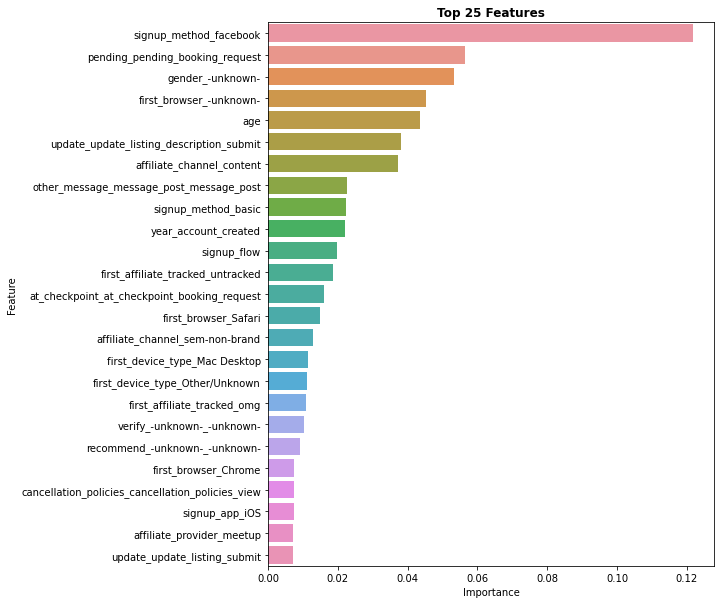

In [ ]:
plt.figure(figsize = (8,10))
sns.barplot(x='Importance', 
            y="Feature", 
            data=G)
plt.title("Top 25 Features",fontweight='bold')
plt.show()

#**RESULTS SUMMARY:**

In [14]:
from prettytable import PrettyTable
PT = PrettyTable()
PT.field_names = ["Model","Best Parameter", "NDCG Score"]
PT.add_row(["XG Boost Model","max_depth: 3,     n_estimators: 100", "0.802097"])
PT.add_row(["Random Forest Model","max_depth: 6,      n_estimators: 50", "0.792653"])
PT.add_row(["Decision Tree Model","max_depth: 5, min_sample_split: 100","0.796815"])
PT.add_row(["Logistic Regression (L1 Penalty) Model","alpha : 1","0.780486"])
print(PT)

+----------------------------------------+-------------------------------------+------------+
|                 Model                  |            Best Parameter           | NDCG Score |
+----------------------------------------+-------------------------------------+------------+
|             XG Boost Model             | max_depth: 3,     n_estimators: 100 |  0.802097  |
|          Random Forest Model           | max_depth: 6,      n_estimators: 50 |  0.792653  |
|          Decision Tree Model           | max_depth: 5, min_sample_split: 100 |  0.796815  |
| Logistic Regression (L1 Penalty) Model |              alpha : 1              |  0.780486  |
+----------------------------------------+-------------------------------------+------------+
